# Explore Simple Cuts

In [1]:
from tomo_challenge import load_data, load_redshift
from tomo_challenge.jax_metrics import ell_binning

Found classifier Random
Found classifier RandomForest
Found classifier IBandOnly


In [2]:
from zotbin.binned import *

In [3]:
init_data = load_binned('binned_40.npz')

Specify the challenge data to use:

In [4]:
bands='griz'
include_colors=False
include_errors=False

In [5]:
train_file='/media/data2/tomo_challenge_data/ugrizy/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 8615613 training rows.


/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


In [6]:
def scan(feature, z, pct):
    ncut = len(pct)
    cuts = np.percentile(feature, pct)
    ibin = np.digitize(feature, cuts)
    score_data = None
    for i in range(ncut):
        idx = 1 * (ibin <= i)
        scores = get_binned_scores(idx, z, *init_data)
        if score_data is None:
            score_data = {t: np.empty(ncut) for t in scores}
        for t in scores:
            score_data[t][i] = scores[t]
    return score_data, cuts

In [7]:
def study_cuts(data, z, ncut=50):
    nband = data.shape[1]
    assert nband == len(bands)
    pct = np.linspace(0, 100, ncut + 2)[1:-1]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    # Enumerate the options to study.
    features = {f'{bands[i]}-{bands[i-1]}': data[:, i] - data[:, i-1] for i in range(1, nband)}
    features['redshift'] = z
    features.update({bands[i]: data[:, i] for i in range(nband)})
    # Apply cuts in each band.
    for option in features:
        scores, _ = scan(features[option], z, pct)
        for i, t in enumerate(scores):
            axes[i].plot(pct, scores[t], '-', label=option)
    for ax, t in zip(axes, scores.keys()):
        ax.set_ylim(0, None)
        ax.set_ylabel(t)
        ax.set_xlabel('Percentile Cut')
        ax.legend(ncol=2)        
    plt.tight_layout()

CPU times: user 44 s, sys: 2.85 s, total: 46.9 s
Wall time: 44.8 s


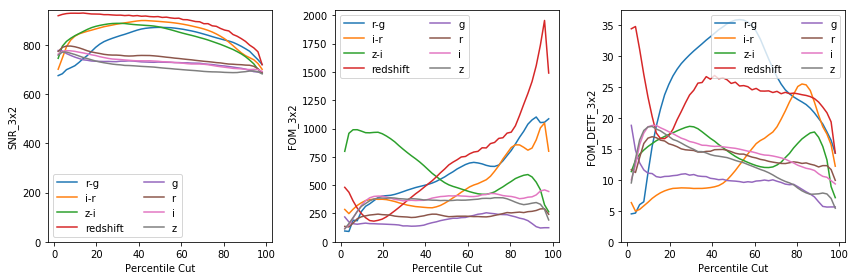

In [8]:
%time study_cuts(train_data[:100000], train_z[:100000])

Compare with results using the Buzzard data:

In [10]:
buzzard_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
buzzard_data = load_data(buzzard_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
buzzard_z = load_redshift(buzzard_file)
print(f'Loaded {len(buzzard_data)} buzzard rows.')

Loaded 5410171 buzzard rows.


CPU times: user 42.7 s, sys: 2.09 s, total: 44.8 s
Wall time: 40.6 s


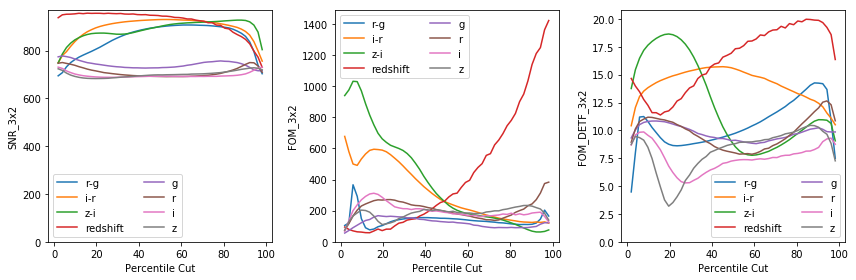

In [11]:
%time study_cuts(buzzard_data[:100000], buzzard_z[:100000])

Why are the buzzard scores significantly lower than the DC2 ones??